프레임워크
- Langchain
- 비슷한 역할을 하는 Llamaindex 등이 있는데, 학습 단계에서는 이들이 유용하지만, 실제 서빙을 위한 서비스를 개발하다 보면 하나 둘 직접 구현하게 되는 경우가 많음.

모델
- gpt-4o-mini
- Langchain ChatOllama 를 활용하면 Langchain 위에 첫날 실습한 Ollama + Local model 을 활용해서 구현할 수 있음

In [1]:
%%capture --no-stderr
%pip install langchain langchain-openai langchain-openai langchain_chroma langchain-text-splitters langchain_community

In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

KeyboardInterrupt: Interrupted by user

**기본 RAG tutorial**

Langchain 에 익숙하지 않으신 분은 아래 링크의 튜토리얼 코드를 한 번 읽고 이해한 다음 아래 과정을 진행해주세요.

(tutorial 에서 이해되지 않는 부분은 강사/조교에게 질문해주세요!)

https://python.langchain.com/v0.2/docs/tutorials/rag/


langchain hub 에서 prompt format 가져다 쓰기

In [8]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

agent 에 대한 post 를 load, split 한 뒤 vectorstore 생성하고, langchain hub 에서 가져온 프롬프트 포맷을 활용해 Task decomposition 이라는 입력 프롬프트에 대한 답변 확인하기

In [9]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


'Task decomposition is the process of breaking down a complicated task into smaller, manageable steps to facilitate planning and execution. It often utilizes techniques like Chain of Thought (CoT) prompting, which encourages models to think step by step, and can involve multiple reasoning possibilities through methods like Tree of Thoughts. This approach enhances problem-solving by making complex tasks easier to handle and understand.'

아래부터는 직접 Task 를 읽고, 문서를 읽고, 코드를 작성, 평가하면서 task 를 풀어보세요.

Task 를 순서대로 하고 나면 아래 이미지와 같이 RAG chain 이 완성됩니다.

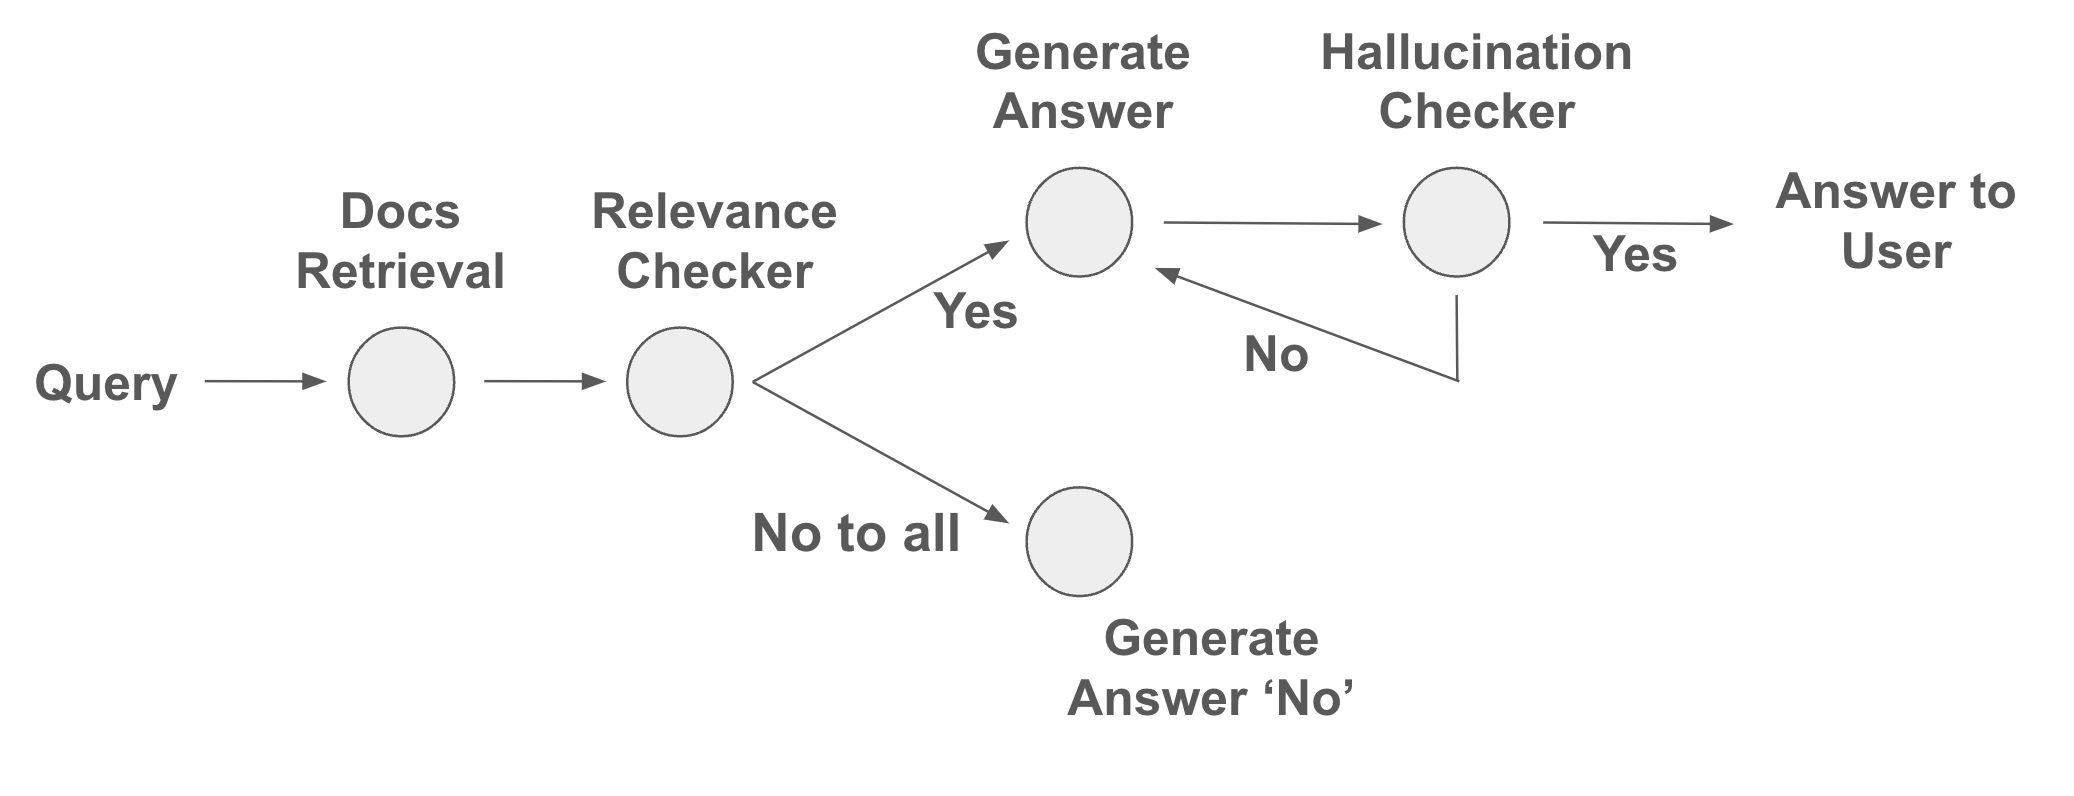

아래 1-10 task 에 대한 코드를, 각각의 task별 참고 링크를 보면서 작성해보세요.

**1. 3개의 블로그 포스팅 본문을 Load하기 : WebBaseLoader 활용**

https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/

In [10]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [11]:
loader = WebBaseLoader(
    web_paths=urls,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

**2. 불러온 본문을 Split (Chunking) : recursive text splitter 활용 (아래 링크 참고)**

https://python.langchain.com/v0.2/docs/how_to/recursive_text_splitter/

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

**3. Chunks 를 임베딩하여 Vector store 저장: openai 임베딩, chroma vectorstore 사용**

이 때,

embedding model 은 "text-embedding-3-small" 사용

embedding: https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/

vetor store: https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/

retriever search_type 은 'similarity', search_kwargs={'k': 6} 을 사용해주세요.

In [14]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(model="text-embedding-3-small"))
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

**4. User query = ‘agent memory’ 를 받아 관련된 chunks를 retrieve**


https://python.langchain.com/v0.2/docs/how_to/vectorstore_retriever/

https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStore.html#langchain_core.vectorstores.VectorStore.as_retriever

In [15]:
answer = retriever.invoke("agent memory")
answer

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)'),
 Document(metadata={'source': 'https://lilianweng.gith

**5. 5-1) 과 5-2) 를 참고하여, User query와 retrieved chunk 에 대해 relevance 가 있는지를 평가하는 시스템 프롬프트를 작성해보세요: retrieval 퀄리티를 LLM 이 스스로 평가하도록 하고, 관련이 있으면 {‘relevance’: ‘yes’} 관련이 없으면 {‘relevance’: ‘no’} 라고 출력하도록 함. ( JsonOutputParser() 를 활용 )**


In [16]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain import hub

parser = JsonOutputParser()
prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: {input}, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

chain = {'retrieved': retriever | format_docs, 'input': RunnablePassthrough()} | prompt | llm | parser

chain.invoke("agent memory")

{'relevance': 'yes'}

5-1 참고) RAG 용 프롬프트 작성을 위한 Prompt Hub 활용

https://smith.langchain.com/hub/rlm/rag-prompt

In [17]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [18]:
example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

5-2 참고) output JSON formatting 하는 코드

https://python.langchain.com/v0.2/docs/how_to/output_parser_json/#without-pydantic

In [19]:
# 5-2 참고 코드
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

joke_query = "Tell me a joke."

parser = JsonOutputParser()

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

chain.invoke({"query": joke_query})

{'joke': "Why don't scientists trust atoms? Because they make up everything!"}

```
{'response': "Sure! Here's a joke for you: Why couldn't the bicycle stand up by itself? Because it was two tired!"}
```

6. 5 에서 모든 docs에 대해 'yes' 가 나와야 하는 케이스와 ‘no’ 가 나와야 하는 케이스를 작성해보세요.

In [20]:
# 적절히 프롬프트를 작성하여 관련성이 있는지 확인하도록 구성하면 yes가 출력되고,
# 프롬프트에 단순히 yes인 경우 no를 출력하게 한다거나, 프롬프트에 구성하는 input에 다른 단어를 넣으면 no가 출력될 것으로 보입니다.
# case: no
prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: funny joke, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# case: yes
prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: {input}, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

7. 5에서 케이스별로 의도한 결과 ('yes' 또는 'no' )와 일치하는 답변이 나오는지 확인해보세요.
 정답대로 나오지 않는다면 문제를 찾아 디버깅해보세요. (Splitter, Chunk size, overlap, embedding model, vector store, retrieval 평가 시스템 프롬프트 등) 디버깅이 어려운 경우,  강사/조교에게 질문해주세요.

In [21]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

parser = JsonOutputParser()
prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: funny joke, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = {'retrieved': retriever | format_docs, 'input': RunnablePassthrough()} | prompt | llm | parser

print(chain.invoke("agent memory"))

prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: {input}, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = {'retrieved': retriever | format_docs, 'input': RunnablePassthrough()} | prompt | llm | parser

print(chain.invoke("agent memory"))

{'relevance': 'no'}
{'relevance': 'yes'}


8. 6-7 의 평가에서 문제가 없다면, 5에서 작성한 코드의 실행 결과가 'yes' 인 경우, 4의 retrieved chunk 를 가지고 답변하는 chain 코드를 작성해주세요. (prompt | llm | parser 형태의 코드)

In [25]:
# 8 을 수행하기 위한 참고 코드
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

relev_prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: {input}, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = {'retrieved': retriever | format_docs, 'input': RunnablePassthrough()} | relev_prompt | llm | parser

relev = chain.invoke("What is Task Decomposition?")
q_prompt = hub.pull("rlm/rag-prompt")
print(relev)

if 'relevance' in relev and relev['relevance'] == 'yes':
  rag_chain = (
      {"context": retriever | format_docs, "question": RunnablePassthrough()}
      | q_prompt
      | llm
      | StrOutputParser()
  )

  for chunk in rag_chain.stream("What is Task Decomposition?"):
      print(chunk, end="", flush=True)
else:
  print("oh no")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'relevance': 'yes'}
Task decomposition is the process of breaking down a complex task into smaller, more manageable steps. It can be done using various methods, such as prompting a language model, providing task-specific instructions, or utilizing human inputs. This approach enhances model performance by allowing for structured reasoning and clearer interpretations of thought processes.

9. 생성된 답안에 Hallucination 이 있는지 평가하는 시스템 프롬프트를 작성해보세요. LLM이 스스로 평가하도록 하고, hallucination 이 있으면 {‘hallucination’: ‘yes’} 없으면 {‘hallucination’: ‘no’} 라고 출력하도록 하세요.

In [29]:
# 8 을 수행하기 위한 참고 코드
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

relev_prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: {input}, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

hallu_prompt = PromptTemplate(
    template="Classify whether there is hallucination between the output and the retrieved chunk as yes or no. If there is wrong information in output, hallucination is yes. Else is no.\n{format_instructions}\output: {output}, information: {retrieved}\n",
    input_variables=["output", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = {'retrieved': retriever | format_docs, 'input': RunnablePassthrough()} | relev_prompt | llm | parser

relev = chain.invoke("What is Task Decomposition?")
q_prompt = hub.pull("rlm/rag-prompt")
print(relev)

if 'relevance' in relev and relev['relevance'] == 'yes':
  rag_chain = (
      {"context": retriever | format_docs, "question": RunnablePassthrough()}
      | q_prompt
      | llm
      | StrOutputParser()
  )

  output = rag_chain.invoke("What is Task Decomposition?")
  print(output)
  hal_chain = (
      {"retrieved": retriever | format_docs, "output": RunnablePassthrough()}
      | hallu_prompt
      | llm
      | parser
  )
  print(hal_chain.invoke(output))
else:
  print("oh no")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'relevance': 'yes'}
Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. This can be accomplished through techniques such as prompting large language models (LLMs) to generate step-by-step reasoning or by using task-specific instructions. It enhances understanding and execution by simplifying intricate tasks into a series of simpler tasks.
{'hallucination': 'no'}


10. 9 에서 ‘yes’ 면 8 로 돌아가서 다시 생성, ‘no’ 면 답변 생성하고 유저에게 답변 생성에 사용된 출처와 함께 출력하도록 하세요. (최대 1번까지 다시 생성)

In [33]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

relev_prompt = PromptTemplate(
    template="Classify whether there is relevance between the input and the retrieved chunk as yes or no.\n{format_instructions}\nuser query: {input}, chunk: {retrieved}\n",
    input_variables=["input", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

hallu_prompt = PromptTemplate(
    template="Classify whether there is hallucination between the output and the retrieved chunk as yes or no. If there is wrong information in output, hallucination is yes. Else is no.\n{format_instructions}\output: {output}, information: {retrieved}\n",
    input_variables=["output", "retrieved"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = {'retrieved': retriever | format_docs, 'input': RunnablePassthrough()} | relev_prompt | llm | parser

relev = chain.invoke("What is Task Decomposition?")
q_prompt = hub.pull("rlm/rag-prompt")
print(relev)

for _ in range(2):
  if 'relevance' in relev and relev['relevance'] == 'yes':
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | q_prompt
        | llm
        | StrOutputParser()
    )

    output = rag_chain.invoke("What is Task Decomposition?")
    print(output)
    hal_chain = (
        {"retrieved": retriever | format_docs, "output": RunnablePassthrough()}
        | hallu_prompt
        | llm
        | parser
    )
    hallu = hal_chain.invoke(output)
    print(hallu)
    if 'hallucination' in hallu and hallu['hallucination'] == 'yes':
      print("hallucination occur! try again")
      continue
    break
  else:
    print("oh no")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'relevance': 'yes'}
Task decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks or steps. This can be achieved through various methods, such as using language model prompts to generate a structured outline or by providing task-specific instructions. The goal is to simplify the overall task, making it easier to understand and execute.
{'hallucination': 'no'}


# 아래는 Optional Task 입니다. 위의 Task 1부터 10까지 시간 내에 마친 분들은 아래 태스크를 수행해보세요.

Optional Task) https://applied-llms.org/ 링크는 llm 을 이용해 1년간 개발해 본 팀이 배운 것들을 정리한 아티클 입니다.

저자의 생각을 묻는 질문들에 답하기 위해서

1) Chunking & embedding & storing

2) Load

3) Retrieval

4) Generation

으로 구성된 RAG 코드를 작성하고 아래 예시 질문에 대한 답을 해보세요.

예시)
RAG 에 대한 저자의 생각은 무엇인가?
RAG 와 fine tuning 에 대해 저자는 어떻게 비교하고 있나?
저자가 가장 많은 부분을 할당해 설명하는 개념은 무엇인가?

실습을 마치지 못했더라도, https://applied-llms.org/ 아티클은 꼭 읽어 보시기를 추천 드립니다.